In [153]:
import numpy as np, matplotlib.pyplot as plt, mahotas as mh
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from skimage.color import label2rgb
from PIL import Image
from itertools import cycle
from scipy.spatial import distance as dist

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [58]:
import cv2, imutils
from imutils import perspective
from imutils import contours

### Mean-shift (MS): 
    - http://efavdb.com/mean-shift/

In [7]:
# Plot figure
def ClusterPlot(X, labels, cluster_centers):
    figure = plt.figure(figsize=(7,3)); ax = figure.add_subplot(111)
    for k, color in zip(range(labels.max()+1), [i for i in 'bgrcmyk']):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        ax.plot(X[my_members, 0], X[my_members, 1], color + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor='k')
    ax.set_title('Estimated number of clusters: %d' % (k+1));
    return ax

In [8]:
#%% Generate sample data
@interact(quantile=(0.1,0.5,0.1),cluster_std=(0.1,1,0.2))
def GenerateInfo(quantile = 0.1, cluster_std= 0.4):
    centers = [[1, 1], [-.75, -1], [1, -1], [-3, 2]]
    X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std = cluster_std)
    # The bandwidth can be automatically estimated
    bandwidth = estimate_bandwidth(X, quantile=quantile,n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True); ms.fit(X)
    labels = ms.labels_; cluster_centers = ms.cluster_centers_; 
    print('Cluster centers', [i for i in cluster_centers])
    ClusterPlot(X, labels, cluster_centers)

interactive(children=(FloatSlider(value=0.1, description='quantile', max=0.5, min=0.1), FloatSlider(value=0.4,…

Application

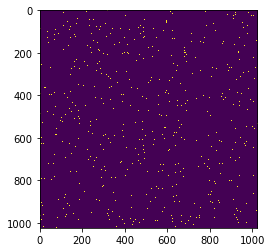

In [7]:
import mahotas as mh
image = Image.open('MyMaxima_Example.tif'); img_array = np.array(image); plt.imshow(img_array!=0)

In [8]:
x_coord, y_coord = np.where(img_array != 0)
spots_coord = np.concatenate([x_coord[:,None], y_coord[:,None]], axis = 1); print(len(spots_coord))

10594


Note: 
- Not useful for small identification. For good results, need colorized difference (more features)

### Marker-based Watershed (Gradient): 
   - https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_marked_watershed.html
   - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html

In [9]:
from scipy import ndimage as ndi

from skimage import data
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(data.camera()); print(image.shape, image.max(), image.min())  # Exmaple image

(512, 512) 255 0


In [11]:
img = plt.imread('FOV34_Cy3S.tif');

In [115]:
@interact(stringency=(0,100,1), blur_factor = (1,50,1), blur_factor_2 = (1,10,1), blur_factor_3 = (1,10,1))
def Watershed(blur_factor = 4, blur_factor_2=5,stringency=10):
    # denoise image
    denoised = rank.mean(mh.stretch(img), disk(blur_factor)); print(denoised.shape)
    # find continuous region (low gradient - where less than 10 for this image) --> markers
    # disk(5) is used here to get a more smooth image  
    markers = rank.gradient(denoised, disk(blur_factor_2)) < stringency ;markers = ndi.label(markers)[0]
    # local gradient (disk(2) is used to keep edges thin)
    gradient = rank.gradient(denoised, disk(2)); print('Gradient matrix:', gradient.max(), gradient.min())
    # process the watershed
    labels = watershed(gradient, markers)
    # display results
    fig, axes = plt.subplots(1,4, figsize=(15, 4)); ax = axes.ravel(); fig.tight_layout()
    ax[0].imshow(denoised, cmap=plt.cm.gray); ax[0].set_title("denoised")
    ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral); ax[1].set_title("Local Gradient")
    ax[2].imshow(markers, cmap=plt.cm.nipy_spectral); ax[2].set_title("Markers")
    ax[3].imshow(img, cmap=plt.cm.gray); ax[3].set_title("Segmented");
    ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7); 
    print('Number of objects', len(np.unique(labels)))
    return labels

interactive(children=(IntSlider(value=4, description='blur_factor', max=50, min=1), IntSlider(value=5, descrip…

(1024, 1024)
Number of objects 176


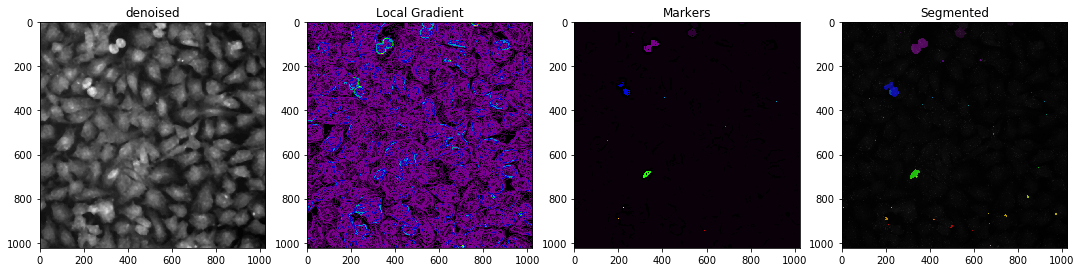

In [17]:
labels = Watershed(stringency=10, blur_factor=5, blur_factor_2=4);    # output determined settings to variable

<b> Watershed with Local Maxima:
- https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
- Comment: Nice & Good

In [186]:
import numpy as np,scipy.ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank
# Generate an initial image with two overlapping circles
x, y = np.indices((40, 40)); x1,y1,x2,y2 = 20,20,24,24; r1, r2 = 4,4
mask_circle1 = (x-x1)**2 + (y-y1)**2 < r1**2; mask_circle2 = (x-x2)**2 + (y-y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

Number of objects detected:  2


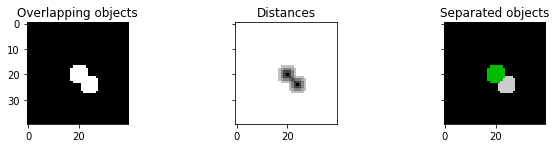

In [187]:
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)), labels=image)
markers = ndi.label(local_maxi)[0]; labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 2), sharex=True, sharey=True); fig.tight_layout(); ax = axes.ravel()
ax[0].imshow(image, cmap=plt.cm.gray); ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray); ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral); ax[2].set_title('Separated objects')
print('Number of objects detected: ', markers.max())

<b> Application (by me)

In [174]:
image = Image.open('FOV34_Cy3S.tif'); img_array = mh.stretch(np.array(image));

In [176]:
@interact(sigma=(0.5,5,0.5), blur_factor=(1,50,1))
def CompareBlur_noBlur(blur_factor=5, sigma=4.5):
    fig = plt.figure(figsize=(8,3)); fig.tight_layout(); 
    gaussian_f = mh.gaussian_filter(img_array, sigma = sigma); g_fitler = gaussian_f>gaussian_f.mean()
    ax1 = fig.add_subplot(121); ax1.imshow(img_array*g_fitler); ax1.set_title('gaussian')
    
    img_blurred= rank.mean(img_array, disk(blur_factor)); gaussian_f = mh.gaussian_filter(img_blurred, sigma = sigma); 
    blurg_filter = gaussian_f>gaussian_f.mean(); filtered_img = img_blurred*blurg_filter;
    ax2 = fig.add_subplot(122); ax2.imshow(filtered_img); ax2.set_title('Blur then Gaussian')
    return g_fitler, blurg_filter

interactive(children=(IntSlider(value=5, description='blur_factor', max=50, min=1), FloatSlider(value=4.5, des…

Note: Blurring before applying the Gaussian allow better identification of local maxima and lower noise

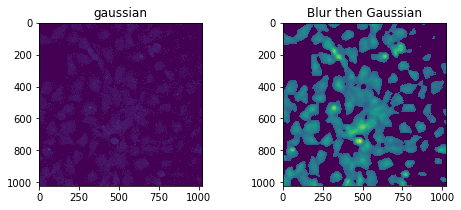

In [177]:
g_filter, blurg_filter = CompareBlur_noBlur(sigma=0.5, blur_factor= 15)

(Documentation) Peak_local_maxi: https://scikit-image.org/docs/0.8.0/api/skimage.feature.peak.html

In [228]:
mask = blurg_filter   # Choose which filter
@interact(footprint=(1,20,1))   # Important parameter
def Segmentation_by_maxi(footprint = 3):
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True); fig.tight_layout(); ax = axes.ravel()
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint, footprint)), labels=mask)
    markers = ndi.label(local_maxi)[0]; labels = watershed(-distance, markers, mask=mask)
    print('Number of objects detected: ', markers.max())
    ax[0].imshow(mask, cmap=plt.cm.gray); ax[0].set_title(' objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray); ax[1].set_title('Distances'); 
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral); ax[2].set_title('Separated objects')
    return labels

interactive(children=(IntSlider(value=3, description='footprint', max=20, min=1), Output()), _dom_classes=('wi…

Number of objects detected:  210


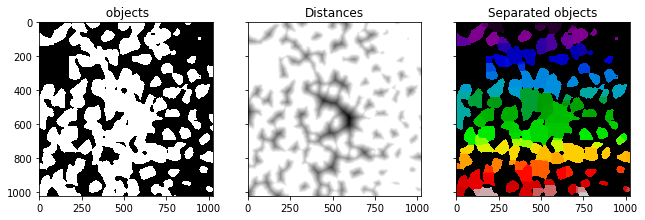

In [229]:
segmax_labels = Segmentation_by_maxi(7)

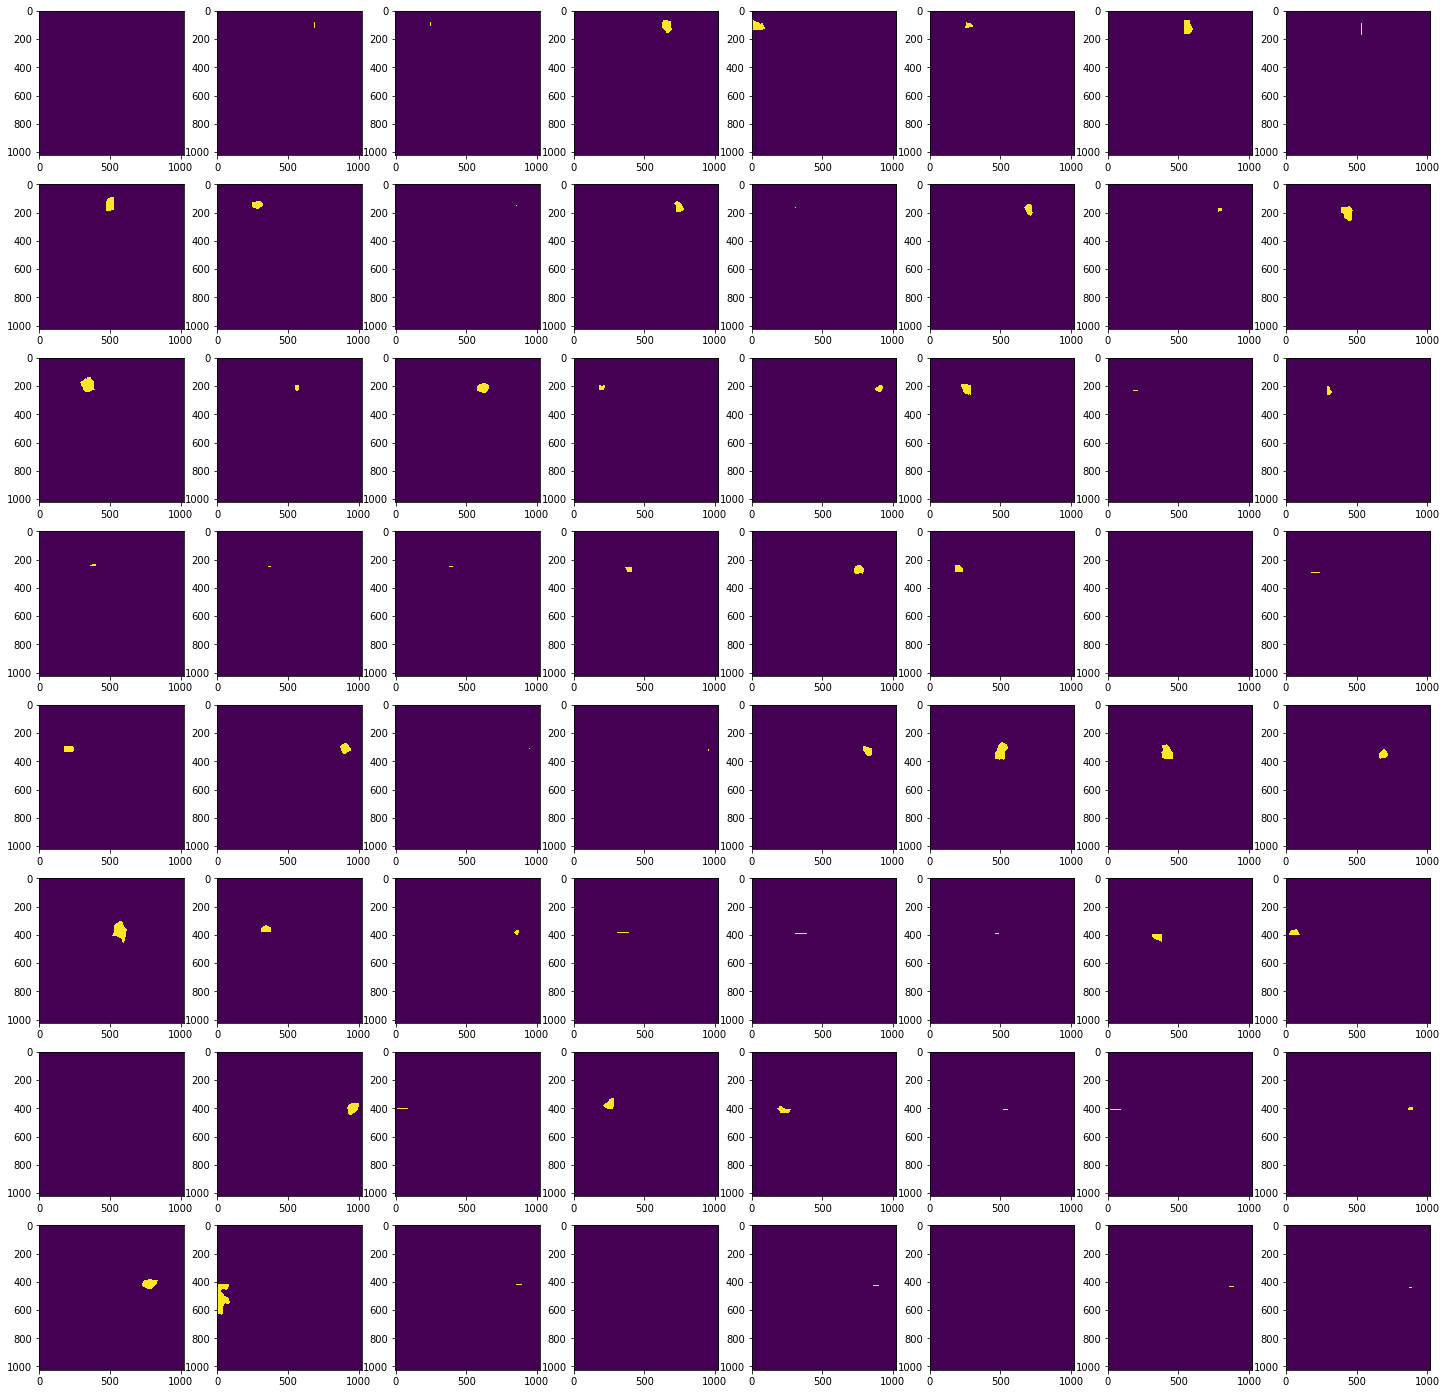

In [230]:
x = 8; y = 8
fig = plt.figure(figsize=(25,25)); start = 20
for n, i in enumerate(range(start, start+x*y)):
    ax = fig.add_subplot(x, y,n+1)
    ax.imshow(segmax_labels==i)

<b> Edge-based vs Region-based Watershed

In [4]:
from skimage import data
from skimage.exposure import histogram
from skimage.feature import canny
from PIL import Image
import mahotas as mh, numpy as np
image = data.coins();  # Example
image = Image.open('DAPI-dual_AZ73.tif'); img_array = mh.stretch(np.array(image));

In [170]:
hist, hist_centers = histogram(img_array); plt.figure(figsize=(6,2)); plt.plot(hist)

In [221]:
# Edge based
@interact(size_thres=(1,100,1))
def EdgeFill_Segmentation(size_thres=30):
    fig, axes = plt.subplots(1,3,figsize=(10,3)); ax = axes.ravel(); fig.tight_layout(); 
    ax[0].imshow(img_array); ax[0].set_title('Original')

    edges = canny(img_array/255); fill_coins = ndi.binary_fill_holes(edges); 
    ax[1].imshow(fill_coins); ax[1].set_title('Filled Holes')
    label_objects, nb_labels = ndi.label(fill_coins); print('1: Number of objects:', nb_labels); 

    sizes = np.bincount(label_objects.ravel()); mask_sizes = sizes > size_thres; mask_sizes[0] = 0; size_cleaned = mask_sizes[label_objects];  
    ax[2].imshow(size_cleaned); ax[2].set_title('Size masked')
    label_objects, nb_labels = ndi.label(size_cleaned); print('2: Number of objects:', nb_labels); 

interactive(children=(IntSlider(value=30, description='size_thres', min=1), Output()), _dom_classes=('widget-i…

<b> Region-based Segmentation

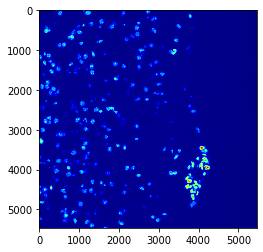

In [24]:
import PIL.Image as Image, mahotas as mh, numpy as np, matplotlib.pyplot as plt, scipy.ndimage as ndi
from skimage.filters import sobel
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import watershed
#image = data.coins();  # Example
image = Image.open('Images/HF_DAPI/BK79_Dapi(1).tif'); img_array = mh.stretch(np.array(image));
plt.imshow(image)

Number of objects: 263


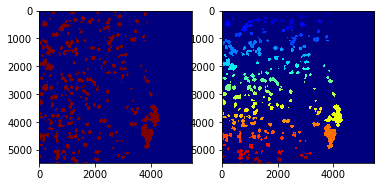

In [25]:
gaussian_f = mh.gaussian_filter(img_array, 2.)
bin_image = gaussian_f > gaussian_f.mean()
plt.subplot(121); plt.imshow(bin_image)
# label the image in order to assign index to each component
labeled, nr_object = mh.label(bin_image); print('Number of objects:',nr_object)
plt.subplot(122); plt.imshow(labeled); plt.jet()

In [26]:
markers = np.zeros_like(img_array); t_mean = img_array.mean()
# Size Markers
markers[img_array>t_mean] = 2; markers[img_array<=t_mean] = 1
# Maxima Markers
#markers = mh.regmax(img_array)
elevation_map = sobel(img_array)

Number of Objects:  609


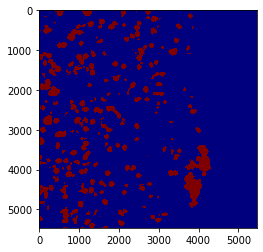

In [27]:
segmentation = watershed(elevation_map, markers)
#segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_objects, nr_objs = ndi.label(segmentation-1); print('Number of Objects: ', nr_objs)
plt.imshow(segmentation)

In [30]:
from skimage.segmentation import find_boundaries
import PIL.Image as pil
boundaries_bin = find_boundaries(segmentation, connectivity=1, mode='thick', background=0)
filename = "BK79_Dapi_boundary.tif"
im = pil.fromarray(boundaries_bin); im.save(filename)

Post-processing (optional)

In [18]:
from skimage.morphology import *

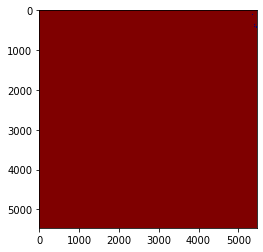

In [21]:
plt.imshow(binary_erosion(img_array))

### Repulsive Level Set (RLS):
- https://wiseodd.github.io/techblog/2016/11/20/levelset-segmentation/

In [208]:
import numpy as np, scipy.ndimage as ndi , scipy.signal, matplotlib.pyplot as plt
from skimage import color, io

F is a velocity field and consider the Level Set PDE above, we want 
F to be high at all region that are not the border of the object we want to segment, and low otherwise. Intuitively, we want the curve to propagate quickly in the background of the image, and we want the curve to slowly propagate or even stop the propagation at the border of the object.

In [211]:
def grad(x):
    return np.array(np.gradient(x))
def norm(x, axis=0):
    return np.sqrt(np.sum(np.square(x), axis=axis))
def stopping_fun(x):
    return 1. / (1. + norm(grad(x))**2)

In [215]:
@interact(sigma=(1,10,.5), blur_factor=(0,20,1))
def RLS(sigma = 4, blur_factor = 4):
    fig, axes = plt.subplots(1,3,figsize = (12,5)); ax = axes.ravel()
    img_rgb = mh.stretch(img); #img = img - np.mean(img)
    # Smooth the image to reduce noise and separation between noise and edge becomes clear
    img_blurred = rank.mean(img_rgb, disk(blur_factor));
    img_smooth = ndi.filters.gaussian_filter(img_blurred, sigma) ; F = stopping_fun(img_smooth)
    ax[0].imshow(img); ax[1].imshow(img_smooth); ax[2].imshow(F> F.mean())
    return F

interactive(children=(FloatSlider(value=4.0, description='sigma', max=10.0, min=1.0, step=0.5), IntSlider(valu…

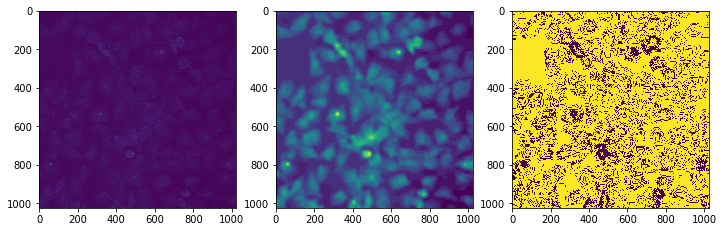

In [216]:
F = RLS(sigma=6.5, blur_factor=7)

In [306]:
def default_phi(x):
    # Initialize surface phi at the border (5px from the border) of the image
    # i.e. 1 outside the curve, and -1 inside the curve
    phi = np.ones(x.shape[:2])
    phi[1:-1, 1:-1] = -1.
    return phi

phi = default_phi(F); dt = 1.
for i in range(25):
    dphi = grad(phi); dphi_norm = norm(dphi)
    dphi_t = F*dphi_norm; phi = phi + dt*dphi_t

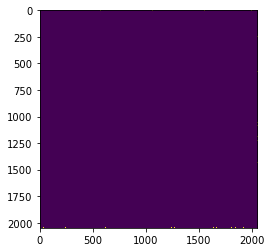

In [307]:
plt.imshow(mh.dilate(mh.stretch(phi)!= 0,np.ones((5,5))))

Geodesic Active Contour

In [ ]:
def curvature(f):
    fy, fx = grad(f)
    norm = np.sqrt(fx**2 + fy**2)
    Nx = fx / (norm + 1e-8)
    Ny = fy / (norm + 1e-8)
    return div(Nx, Ny)

def div(fx, fy):
    fyy, fyx = grad(fy)
    fxy, fxx = grad(fx)
    return fxx + fyy


def dot(x, y, axis=0):
    return np.sum(x * y, axis=axis)

v = 1.; dt = 1.

g = stopping_fun(img_smooth, alpha); dg = grad(g)

for i in range(n_iter):
    dphi = grad(phi); dphi_norm = norm(dphi)
    kappa = curvature(phi)

    smoothing = g * kappa * dphi_norm
    balloon = g * dphi_norm * v
    attachment = dot(dphi, dg)

    dphi_t = smoothing + balloon + attachment

    phi = phi + dt * dphi_t